# Chimpanzees

<img src="https://www.fauna-flora.org/wp-content/uploads/2023/05/GettyImages-625850102-scaled-1.jpg" alt="chimpanzee" width="50%"/>

&copy; Fauna & Flora

Recordings from:

Plooij, F. X. et al. (2015). An archive of longitudinal recordings of the vocalizations of adult Gombe chimpanzees. *Scientific Data*. [https://www.doi.org/10.1038/sdata.2015.27](https://www.doi.org/10.1038/sdata.2015.27)

## Setup

In [1]:
#import packages
import chatter
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
#set config parameters that depart from defaults
config = {
    #spectrogram parameters
    'n_mels': 128,
    'fmin': 0,
    'fmax': 4000,

    #preprocessing parameters
    'use_biodenoising': True,
    'use_noisereduce': True,
    'high_pass': 100,
    'low_pass': 4000,
    'threshold': 2,
    'target_dbfs': -20,
    'compressor_amount': -20,
    'limiter_amount': -10,

    #simple segmentation parameters
    'simple_noise_floor': -60,
    'simple_silence_threshold_db': -30,
    'simple_min_silence_length': 0.00001,
    'simple_max_unit_length': 2,
    'simple_min_unit_length': 0.1,
    
    #other parameters
    'plot_clip_duration': 10
}
config = chatter.make_config(config)

#initialize the analyzer with the configuration
#using only 8 cores to avoid memory crash during segmentation
analyzer = chatter.Analyzer(config, n_jobs = 8)
model = chatter.Trainer(config)

#set paths
input_dir = Path("/Volumes/Expansion/data/chatter/examples/chimpanzee/recordings/raw")
processed_dir = Path("/Volumes/Expansion/data/chatter/examples/chimpanzee/recordings/processed")
h5_path = Path("/Volumes/Expansion/data/chatter/examples/chimpanzee/spectrograms.h5")
csv_path = Path("/Volumes/Expansion/data/chatter/examples/chimpanzee/spectrograms.csv")
model_dir = Path("/Volumes/Expansion/data/chatter/examples/chimpanzee/model")
output_csv_path = Path("/Volumes/Expansion/data/chatter/examples/chimpanzee/output.csv")

Using 8 cores for parallel processing
Initializing convolutional variational autoencoder
Using device: mps


## Preprocessing

--- Demoing preprocessing for: Adults+1.wav ---
   Segment: 304.84s - 314.84s


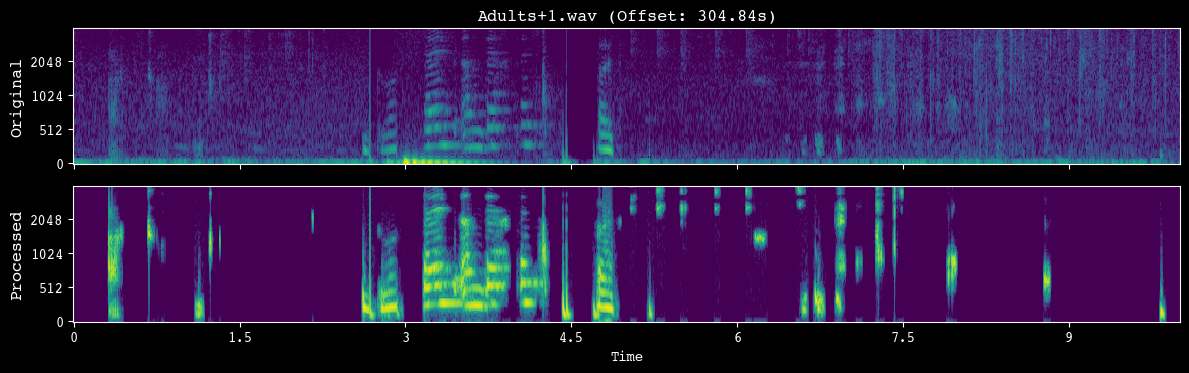

In [7]:
#demo the preprocessing pipeline
analyzer.demo_preprocessing(input_dir)

In [8]:
#preprocess recordings
analyzer.preprocess_directory(input_dir = input_dir, processed_dir = processed_dir)

--- Found 7 audio files to preprocess ---


Preprocessing audio: 100%|██████████| 7/7 [03:08<00:00, 26.89s/it]


--- Preprocessing complete. Standardized WAV audio saved to /Volumes/Expansion/data/chatter/examples/chimpanzee/recordings/processed ---


## Segmentation

--- Demoing segmentation for: Adults+2.wav ---
   Segment: 478.61s - 488.61s


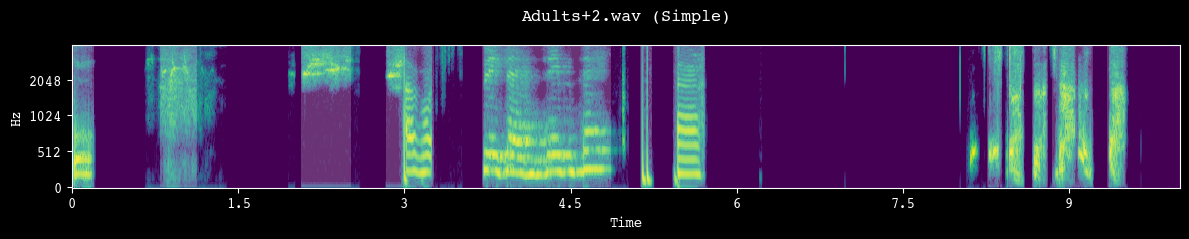

--- Demoing segmentation for: Adults+3.wav ---
   Segment: 439.83s - 449.83s


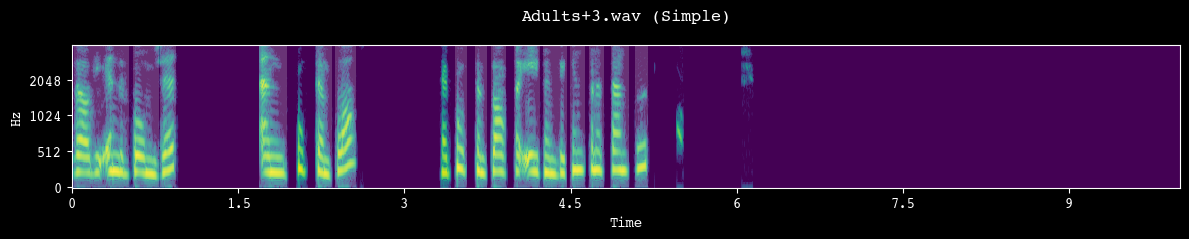

--- Demoing segmentation for: Adults+1.wav ---
   Segment: 188.92s - 198.92s


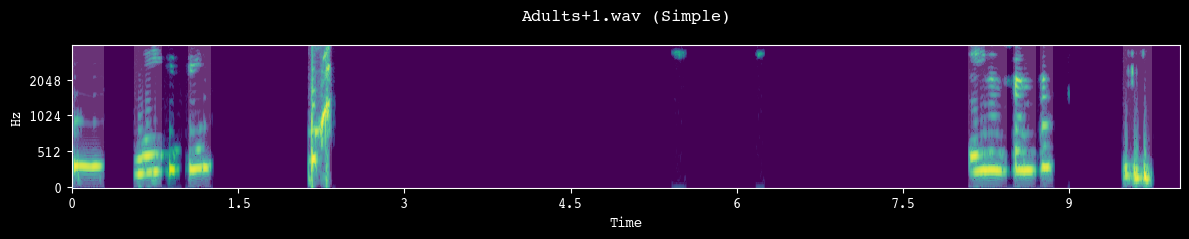

--- Demoing segmentation for: Adults+1.wav ---
   Segment: 155.11s - 165.11s


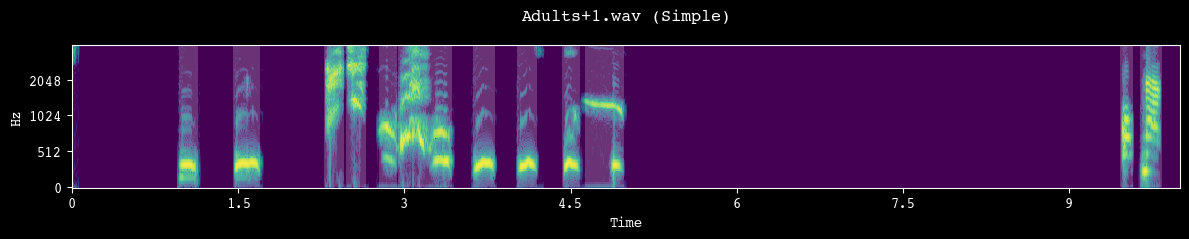

In [9]:
#preview the segmentation pipeline
analyzer.demo_segmentation(input_dir = processed_dir, simple = True)
analyzer.demo_segmentation(input_dir = processed_dir, simple = True)
analyzer.demo_segmentation(input_dir = processed_dir, simple = True)
analyzer.demo_segmentation(input_dir = processed_dir, simple = True)

In [10]:
#segment units and save spectrograms
unit_df = analyzer.segment_and_create_spectrograms(processed_dir = processed_dir, h5_path = h5_path, csv_path = csv_path, simple = True)


--- Found 7 files to segment using simple (amplitude-based) method ---


Segmenting and saving spectrograms: 100%|██████████| 7/7 [00:28<00:00,  4.12s/it]



--- Data preparation complete. Created records for 9744 units ---
Spectrograms saved to /Volumes/Expansion/data/chatter/examples/chimpanzee/spectrograms.h5
Unit metadata saved to /Volumes/Expansion/data/chatter/examples/chimpanzee/spectrograms.csv


## Run model

In [11]:
#load segmented units
unit_df = analyzer.load_df(csv_path)

Attempting to load /Volumes/Expansion/data/chatter/examples/chimpanzee/spectrograms.csv...
--- Successfully loaded /Volumes/Expansion/data/chatter/examples/chimpanzee/spectrograms.csv ---


In [12]:
#train ae
model.train_ae(unit_df = unit_df, h5_path = h5_path, model_dir = model_dir, subset = 0.1)

--- Training on a random subset of 974 units (10.0%) ---

Starting training for 100 epochs using 4 DataLoader workers...


Training model: 100%|██████████| 100/100 [03:38<00:00,  2.19s/it, loss=594.8712]


--- Training complete. Model saved to /Volumes/Expansion/data/chatter/examples/chimpanzee/model/model.pth ---
Loss history saved to /Volumes/Expansion/data/chatter/examples/chimpanzee/model/loss.csv


In [14]:
#load trained vae
model = chatter.Trainer.from_trained(config, model_dir)

Instantiating Trainer from pre-trained model at /Volumes/Expansion/data/chatter/examples/chimpanzee/model...
Initializing convolutional variational autoencoder
Using device: mps
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/chimpanzee/model/model.pth


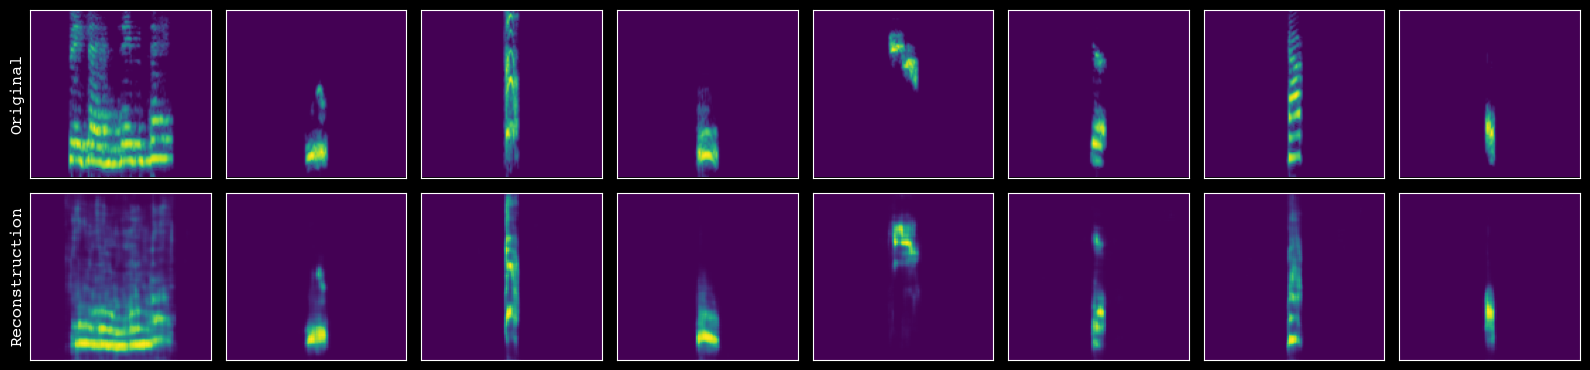

In [38]:
#assess the quality of reconstruction
model.plot_reconstructions(unit_df = unit_df, h5_path = h5_path)

In [39]:
#export the latent features
output = model.extract_and_save_features(unit_df = unit_df, h5_path = h5_path, model_dir = model_dir, output_csv_path = output_csv_path)


--- Starting feature extraction ---
Successfully loaded pre-trained model from /Volumes/Expansion/data/chatter/examples/chimpanzee/model/model.pth


Extracting features: 100%|██████████| 153/153 [00:06<00:00, 23.61it/s]



--- Pipeline complete. Exported data for 9744 units to /Volumes/Expansion/data/chatter/examples/chimpanzee/output.csv ---


## Postprocessing

In [40]:
#load in latent features
output = chatter.FeatureProcessor(analyzer.load_df(output_csv_path), config)

Attempting to load /Volumes/Expansion/data/chatter/examples/chimpanzee/output.csv...
--- Successfully loaded /Volumes/Expansion/data/chatter/examples/chimpanzee/output.csv ---


In [41]:
#process output and save
output.run_pacmap()
output.df.to_csv(output_csv_path, index = False)

--- Running PaCMAP dimensionality reduction ---
--- PaCMAP complete ---


--- Automatically selecting focal points from quadrants with seed 111111 ---
--- Finding nearest neighbors ---
--- Creating the plot ---
--- Plotting density background (using fast 2d histogram) ---
--- Calculating callout positions and adding spectrograms ---
--- Displaying plot ---


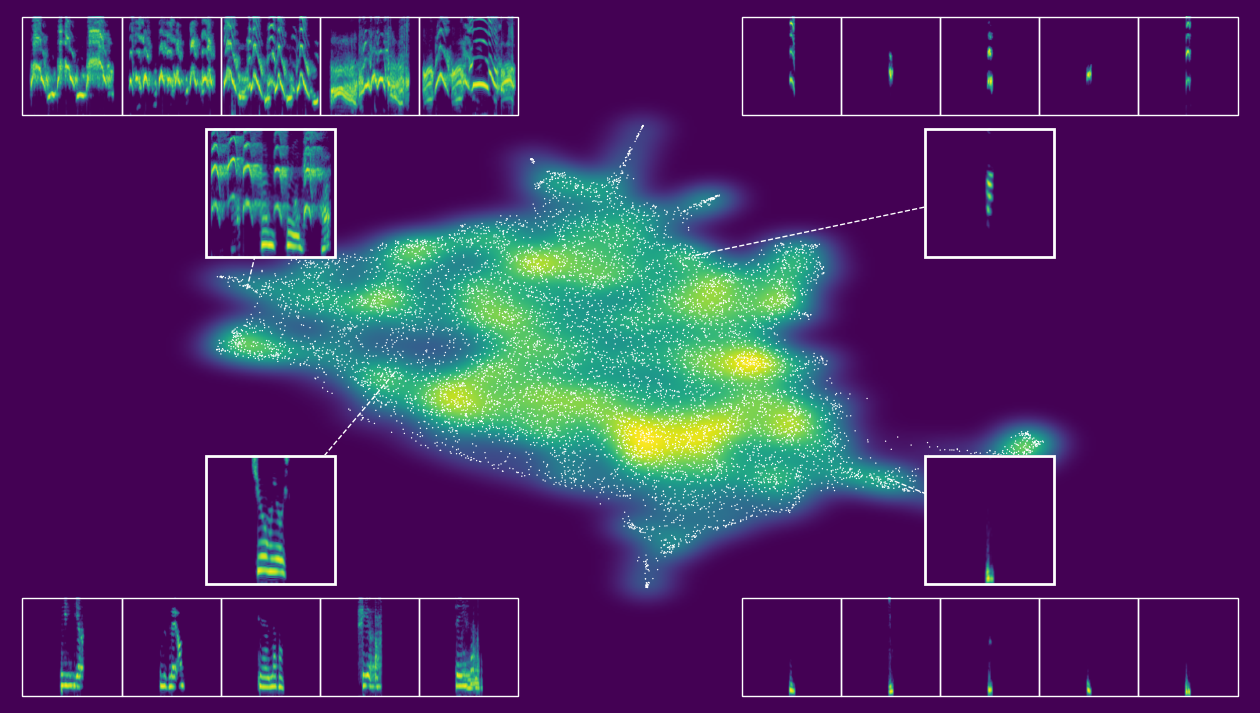

In [63]:
#create interactive or static plot
output.static_embedding_plot(h5_path = h5_path, seed = 111111, focal_quantile = 0.5, point_size = 1, point_alpha = 1, margin = 0.01, zoom_padding = 0.25, num_neighbors = 5)